## Deep learning demystified: HIV protease substrate prediction #2

In the last post we tried to predict peptides cleaved by the HIV protease. While training our first deep neural network we observed that it was not *learning* but rather *remembering* the training data aka overfitting.
Here we will try to fix it and introduce some more deep learning concepts.

First we will quickly regenerate the training and test data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


def qc_plots(history, pre='100units2hidden'):
    plt.subplot(211)
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.subplot(212)
    plt.ylabel('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='val')
    plt.xlabel('Training epoch')
    plt.legend()
    plt.savefig('{}_training.pdf'.format(pre), bbox_inches='tight', dpi=1600)
    plt.show()


def preprocess_seq(df, aa):
    """
    receive a two column df with df[0] is a peptide and df[1] is class label
    returns encoded features as integer and labels
    """
    char_dict = {}
    for index, val in enumerate(aa):
        char_dict[val] = index+1

    # now that we have a dictionary we can just split the sequence in multiple column
    sequences = df[0].str.split('', expand=True)

    # and replace every letter with a number
    for colname in list(sequences):
        sequences[colname] = sequences[colname].str.upper().map(char_dict)
    
    # there are empty columns, we are just going to drop them
    sequences.dropna(axis=1, inplace=True)
    return sequences.values, df[1].values


aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


data1 = pd.read_csv('746Data.txt', sep=",", header=None)
data2 = pd.read_csv('1625Data.txt', sep=",", header=None)
data3 = pd.read_csv('impensData.txt', sep=",", header=None)
test_data = pd.read_csv('schillingData.txt', sep=",", header=None)

# merge all data in single dataframe
tots = pd.concat([data1, data2, data3])

# get features and labels
X, y = preprocess_seq(tots, aa)
X_test, y_test = preprocess_seq(test_data, aa)

# replace -1 with 0 for prediction
y[y == -1] = 0
y_test[y_test == -1] = 0
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)




The last model that we used was this one were we used 2 hidden layers with 100 units each. 

In [20]:
from numpy.random import seed
seed(1)

model = Sequential()
model.add(Dense(units = 100, input_dim=X.shape[1], activation = 'relu', name='hidden1'))
model.add(Dense(units = 100, activation = 'relu', name='hidden2'))
model.add(Dense(units = 1, activation = 'sigmoid', name='output'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['acc'], lr=0.001)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               900       
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 11,101
Trainable params: 11,101
Non-trainable params: 0
_________________________________________________________________


While this model performed good on the training data it did not seem to learn anything on the validation data as the accuracy was stable for every epoch (cycle of training).
Several strategies for dealing with this situations are possible and we will try some of them.
First we will fit the original model and then try several different models with some tweaks

In [21]:
def metrics(model, X_test, y_test, nm):
    yhat_probs = model.predict(X_test, verbose=0)
    yhat_classes = model.predict_classes(X_test, verbose=0)
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]

    accuracy = accuracy_score(y_test, yhat_classes)
    precision = precision_score(y_test, yhat_classes)
    recall = recall_score(y_test, yhat_classes)
    f1 = f1_score(y_test, yhat_classes)
    auc = roc_auc_score(y_test, yhat_probs)
    return [nm, accuracy, precision, recall, f1, auc] 



history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=128, 
                    verbose=0
                    )
base_perf = metrics(model, X_test, y_test, nm='base dnn')

### Save the best performing model (not the last one)

The weights of a DNN are tuned at every epoch. Instead of selecting the model *at the end* of the training, we can pick the model which *performed* better on the validation set as this set is evaluated at every epoch.

For doing so, we will save the weight of the best model and then reload them into a empty architecture (i.e not trained network).

This is pretty much a thing we will always do to keep the best performing model and reduce overfitting. To avoid copy paste we will wrap it up in a function

In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

checkpoint_name = 'tmp_weights.hdf5'

# we will save the model achieving highest accuracy (val_acc) and mode max
# or mode with lowest loss (preferred)
checkpoint = ModelCheckpoint(checkpoint_name, 
                             monitor='val_acc', 
                             verbose = 0, 
                             save_best_only = True, 
                             mode ='max', 
                             patience=10
                            )
callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=128, 
                    verbose=0,
                    callbacks=callbacks_list)

# load weight into current structure
model.load_weights(checkpoint_name) 

best_epoch_perf = metrics(model, X_test, y_test, nm='best_epoch_dnn')

### Reduce model size!

While random forest or ensamble algorithms benefits by using the largest possible number of classifier neural networks are very prone to overfit in large networks and is important to understand the relationship between the number of features, the number of neurons and the number of layers.


So our architecture (2 layers with 100 neurons) might just be *too powerful for our task!*
Let's try a easier one with 2 layers with 20 neurons


In [23]:
model = Sequential()
model.add(Dense(units = 20, input_dim=X.shape[1], activation = 'relu', name='hidden1'))
model.add(Dense(units = 20,  activation = 'relu', name='hidden2'))
model.add(Dense(units = 1, activation = 'sigmoid', name='output'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['acc'], lr=0.001)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 20)                180       
_________________________________________________________________
hidden2 (Dense)              (None, 20)                420       
_________________________________________________________________
output (Dense)               (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________


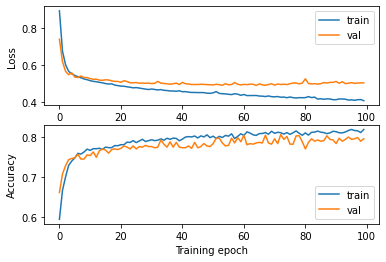

['simple dnn',
 0.828239608801956,
 0.12352941176470589,
 0.04838709677419355,
 0.0695364238410596,
 0.511570262695544]

In [24]:
def get_checkpoint(fl, metr):
    modes = {'val_acc':'max', 'val_loss':'min'}
    checkpoint = ModelCheckpoint(fl, 
                                 monitor=metr, 
                                 verbose = 0, 
                                 save_best_only = True, 
                                 mode =modes[metr], 
                                 patience=10
                                )
    return [checkpoint]


history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=128, 
                    verbose=0,
                    callbacks=get_checkpoint('tmp_weights.hdf5', 'val_loss'))

model.load_weights(checkpoint_name) 
simple_dnn_perf = metrics(model, X_test, y_test, nm='simple dnn')
qc_plots(history, 'simple dnn')
simple_dnn_perf

**Wow, what a difference!** we can see clearly that now our model is learning something but poorly (loss for the training set is kinda high). But compared to before the validation accuracy and loss follows the same trend as the training one which is *exactly what should happen*.
Let's stick with this architecture and how we can further improve it

### Batch size and learning


Batch size as we seen before is a even size chunk of data. For example we used 128 which means the model will go through the entire dataset 128 peptides at the time. 

- *Smaller batches such as 32 or 64 are noisy (as they resemble less the original training data) and can help with overfitting* however it is possible that the batches will be too different resulting in not learning anything
- Large batches represents better the training data and help the model converge to a *global optimum* rather than a local optimum but they are slower to train

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 20)                180       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
hidden2 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________


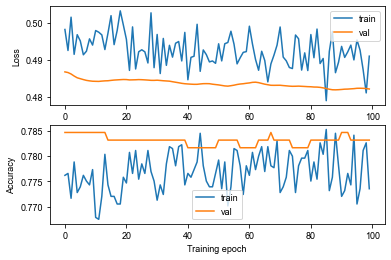

In [37]:
model.summary()
history1024batch = model.fit(X_train, y_train, 
                           validation_data=(X_val, y_val), 
                           epochs=100, 
                           batch_size=1024, 
                           verbose=0,
                           callbacks=get_checkpoint('tmp_weights.hdf5', 'val_loss')
                           )

batch1024_perf = metrics(model, X_test, y_test, nm='1024 batch size dnn')


history32batch = model.fit(X_train, y_train, 
                           validation_data=(X_val, y_val), 
                           epochs=100, 
                           batch_size=32, 
                           verbose=0,
                           callbacks=get_checkpoint('tmp_weights.hdf5', 'val_loss')
                           )

batch32_perf = metrics(model, X_test, y_test, nm='32 batch size dnn')
qc_plots(history1024batch, '1024 batch size')

### Dropout to increase generalization

A popular way to increase the model capability to generalize is to use [Dropout](https://en.wikipedia.org/wiki/Dropout_(neural_networks)). The idea is that we can remove randomly some connection at every epoch (i.e *making the model forget things*) and this forces the model to not rely on specific connections but rather learn a more general representation.

In [26]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(units = 20, input_dim=X.shape[1], activation = 'relu', name='hidden1'))
# drop 20% of connections
model.add(Dropout(0.2))
model.add(Dense(units = 20, activation = 'relu', name='hidden2'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', name='output'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['acc'], lr=0.001)

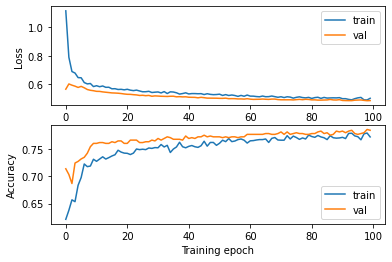

In [27]:
historydropout = model.fit(X_train, y_train, 
                           validation_data=(X_val, y_val), 
                           epochs=100, 
                           batch_size=64, 
                           verbose=0,
                           callbacks=get_checkpoint('tmp_weights.hdf5', 'val_loss')
                           )
dropout_perf = metrics(model, X_test, y_test, nm='dropout dnn')
qc_plots(historydropout, 'dropout dnn')

### Final trick (for now)

We tried tweaking the model with very mild improvements. So what to do now?
*We need to think about what we are trying to classify*

It boils down to **which features are we using to classify what**.

We are dealing with a peptide which means the *order* is important aka **aminoacid X needs to be in position Y** to be a cleavable peptide. Now we are NOT loooking at the order but mostly on the composition.

I will go into types of neural network architecture dealing with sequential data in a follow up post where I will explain how this mysterious dnn achieved such a high performance (and how these nets can be used to perform very interesting tasks in proteomics such as peptide fragmentation prediction)

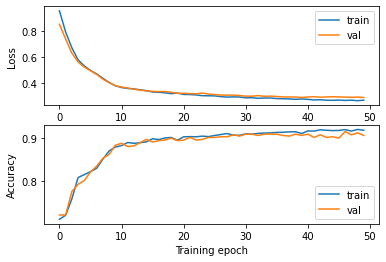

In [28]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers
import tensorflow as tf


max_length = 8
lstmbi = Sequential()
lstmbi.add(Input(shape=(8,)))
lstmbi.add(Embedding(22, 128, input_length=max_length))
lstmbi.add(Bidirectional(LSTM(30, kernel_regularizer=regularizers.l2(0.001), 
                                 recurrent_regularizer=regularizers.l2(0.001), 
                                 bias_regularizer=regularizers.l2(0.001))))
lstmbi.add(Dropout(0.3))
# lstmbi.add(Dense(8, activation='relu'))
# lstmbi.add(Dropout(0.25))
lstmbi.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstmbi.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
history= lstmbi.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=128, 
                    callbacks=get_checkpoint('tmp_weights.hdf5', 'val_loss'), 
                    verbose=0)
callbacks_list = [checkpoint]
lstmbi.load_weights(checkpoint_name)

qc_plots(history, 'LSTM Bi')

In [29]:
lstm_perf = metrics(lstmbi, X_test, y_test, nm='mysterious dnn')

Finally to compare with all models we trained before, we will also quickly re-train the random forest model we used before and compare its performance with all the neural nets we used so far

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

clf_rf = RandomForestClassifier(random_state=42, n_estimators=1000)
clf_rf=clf_rf.fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)
tn,fp,fn,tp = confusion_matrix(y_test, y_pred).ravel()

recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp+tn) / (tp+fp+tn+fn)
f1 = 2 * ((precision*recall) / (precision+recall))
auc = roc_auc_score(y_test, clf_rf.predict_proba(X_test)[:,1])

rf_metr = ['rf', accuracy, precision, recall, f1, auc] 

In [39]:
ls = [dropout_perf, base_perf, batch32_perf, batch1024_perf, lstm_perf, rf_metr]
perf_df = pd.DataFrame(ls, columns=['clf', 'accuracy', 'precision', 'recall', 'f1', 'auc'])
perf_df

,clf,accuracy,precision,recall,f1,auc
0,dropout dnn,0.856357,0.153846,0.018433,0.032922,0.514406
1,base dnn,0.800733,0.175595,0.135945,0.153247,0.570248
2,32 batch size dnn,0.854829,0.098039,0.011521,0.020619,0.515348
3,1024 batch size dnn,0.854218,0.158730,0.023041,0.040241,0.507113
4,mysterious dnn,0.866443,0.496350,0.470046,0.482840,0.850084
5,rf,0.870416,0.569444,0.094470,0.162055,0.831019


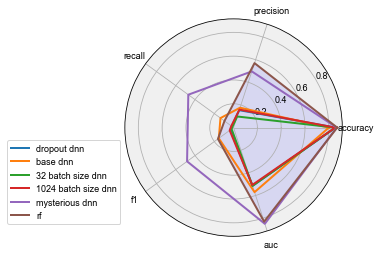

In [40]:
def radarplot(df, nm):
    import math as m
    font = {'size': 9}
    plt.rc('font', **font)
    plt.rcParams["font.family"] = "arial"
    categories = list(df)[1:]
    N = len(categories)
    values = df.loc[0].drop('clf').values.flatten().tolist()
    values += values[:1]
    angles = [n / float(N) * 2 * m.pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(111, polar=True)
    ax.set_facecolor('#F0F0F0')

    plt.xticks(angles[:-1], categories, color='black', size=9)

    ax.set_rlabel_position(30)
    # min and max [0.72, 1], middle circle is 0.86
    #plt.yticks([0.72, 0.86, 1], ["0.72", "0.86", "1.0"], color="black", size=9)
    # plt.ylim(0.72,1)

    for idx, nm in enumerate(nm):
        values = df.loc[idx].drop('clf').values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=nm)
        # ax.fill(angles, values, 'b', alpha=0.1)

  
    # Add legend
    plt.legend(loc='right', bbox_to_anchor=(0, 0.25), fontsize=9)


    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.savefig('./legend.pdf', dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()
    
radarplot(perf_df, nm=list(perf_df['clf']))


### When you have a hammer everything should (not) look like a nail

We just spent a lot of time trying to optimize our feed-forward neural network to outperfom random forest and we did not see a huge improvement even from the base model, until we switched to a complicated architecture (*recurrent neural network*).

So the main takeway from this post is **do not use neural networks all the times only because they are easy to implement!**

In the following posts we will finish this series by looking at some (complicated) neural networks architecture using computer vision and recurrent neural networks and how they can be applied for some more advanced tasks such as peptide fragmentation prediction or retention time prediction.